In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib.colors import LogNorm

## load raw data


In [ ]:
def electron_photon(sample = 100000):
    file_path_electron = "/content/electron.hdf5"
    with h5py.File(file_path_electron, "r") as file:
        X_e = np.array(file["X"])
        y_e = np.array(file["y"])

    file_path_photon = "/content/photon.hdf5"
    with h5py.File(file_path_photon, "r") as file:
        X_p = np.array(file["X"])
        y_p = np.array(file["y"])

    X = np.concatenate((X_e[:sample], X_p[:sample]), axis=0)
    y = np.concatenate((y_e[:sample], y_p[:sample]), axis=0)

    return X, y

In [ ]:
X, y = electron_photon( sample = 100000)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# data is uniform. Equals samples of 0 and 1 classes
import pandas as pd
pd.Series(Y_train).value_counts()

,count
0.0,80000
1.0,80000


## eletron.hdf5
contains 249 000 samples of (32,32,2) images related to simulated electron events in the Electromagnetic Calorimeter.



## photon.hdf5
Also, contains 249 000 samples of (32,32,2) images related to simulated photon events in the Electromagnetic Calorimeter.


We are using 100 k events for photon and 100k events for electron. This is 200 k samples.

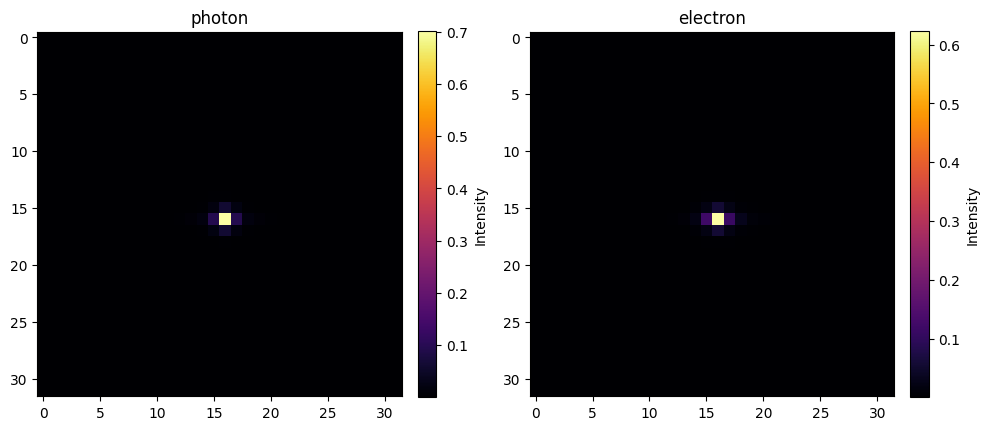

In [ ]:
# Calculate the average for each class
photon_avg = np.mean(X_train[:][Y_train[:] == 0], axis=0)
electron_avg = np.mean(X_train[:][Y_train[:] == 1], axis=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# mean values plot for photons
im1 = axs[0].imshow(photon_avg[:, :, 0], cmap='inferno')
axs[0].title.set_text('photon')

# mean values plot for electron
im2 = axs[1].imshow(electron_avg[:, :, 0], cmap='inferno')
axs[1].title.set_text('electron')

# Añadir la barra de color a cada imagen
cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical', fraction=0.046, pad=0.04)
cbar1.set_label('Intensity')

cbar2 = fig.colorbar(im2, ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)
cbar2.set_label('Intensity')


fig.tight_layout()
plt.show()

## processing


In this part, we preprocessed the raw data. We resized the data to 16x16x1 and we use the bilinear reduction method.

In [ ]:
x_red = X
y_red = y

batch_size = 500
num_batches = x_red.shape[0] // batch_size
events = num_batches * batch_size
file_name = "E-P_rescaled"
channel = 0
crop_fraction = 0.8

output_shape = (16,16,1)
events

200000

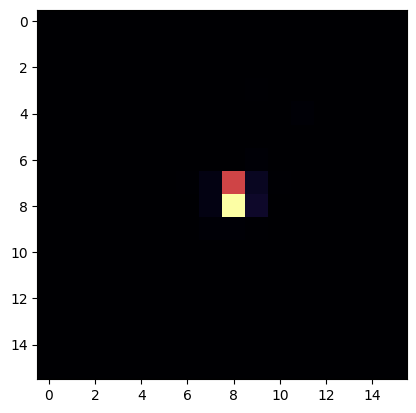

In [ ]:
def crop_and_resize(x, channel, scale, crop_fraction=0.8,meth="bilinear"):
    cropped = tf.image.central_crop(x[:,:,:,channel].reshape(x.shape[0],32,32,1), crop_fraction)
    return tf.image.resize(cropped, (scale,scale), method=meth).numpy()

## example of the reduction using 5 samples
x_small = crop_and_resize(np.array(x_red)[:5], channel, output_shape[0], crop_fraction=crop_fraction)

plt.imshow(x_small[2], cmap = 'inferno')

## Create new file
Here, we create the file

In [ ]:
fnew = h5py.File(file_name, "w")

dsetx = fnew.create_dataset("X", (events,) + output_shape, dtype='f')
dsety = fnew.create_dataset("y", (events,), dtype='i')

for i in range(int(num_batches)):
    y = y_red[i * batch_size: (i + 1) * batch_size]
    x = x_red[i * batch_size: (i + 1) * batch_size]

    x_small = crop_and_resize(np.array(x), channel, output_shape[0], crop_fraction=crop_fraction)

    div1 = np.max(x_small, axis=(1,2)).reshape((x.shape[0],1,1,1))
    div1[div1 == 0] = 1
    x_small = x_small / div1

    dsety[i * batch_size: (i + 1) * batch_size] = y
    dsetx[i * batch_size: (i + 1) * batch_size] = x_small.reshape((x_small.shape[0],)+output_shape)
    print("batch ",i,"/",num_batches, end="\r")

fnew.close()

In [ ]:
path_ep ="/home/lazaror/quantum/pruebas/EQCNN_local_testing/EQNN_for_HEP/Equivariant_QCNN/data/E-P_rescaled"
with h5py.File(path_ep, "r") as file:
    X_ep = np.array(file["X"])
    y_ep = np.array(file["y"])

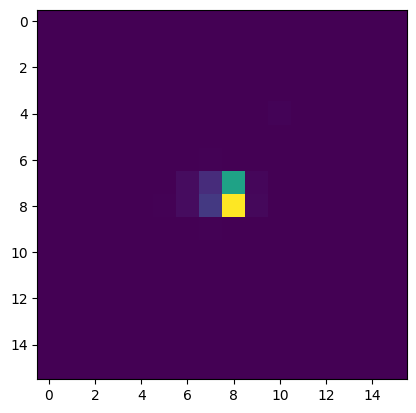

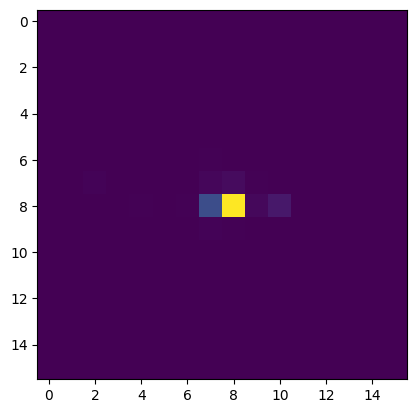

In [ ]:
plt.imshow(X_ep[y_ep==0][0])
plt.show()
plt.imshow(X_ep[y_ep==1][0])
plt.show()

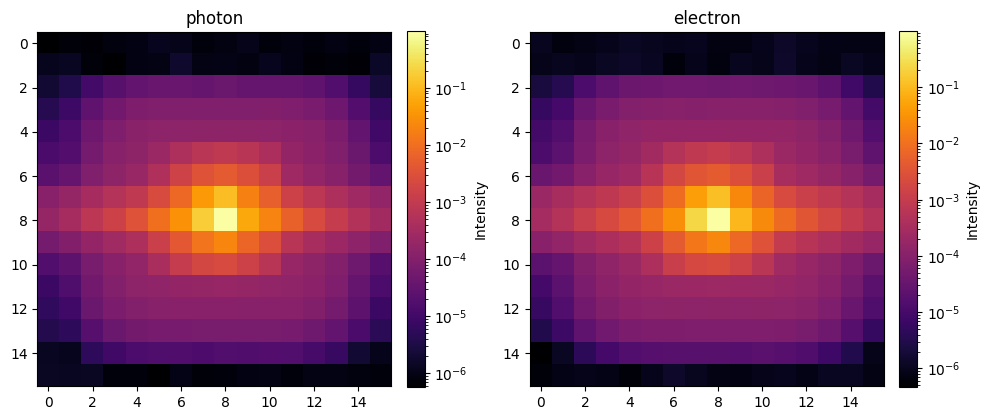

In [ ]:
# Calculate the average for each class
photon_avg = np.mean(X_ep[y_ep == 0], axis=0)
electron_avg = np.mean(X_ep[y_ep == 1], axis=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# mean values plot for photons
im1 = axs[0].imshow(photon_avg[:, :], norm=LogNorm(), cmap='inferno')
axs[0].title.set_text('photon')

# mean values plot for electron
im2 = axs[1].imshow(electron_avg[:, :], norm=LogNorm(), cmap='inferno')
axs[1].title.set_text('electron')

# Añadir la barra de color a cada imagen
cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical', fraction=0.046, pad=0.04)
cbar1.set_label('Intensity')

cbar2 = fig.colorbar(im2, ax=axs[1], orientation='vertical', fraction=0.046, pad=0.04)
cbar2.set_label('Intensity')

fig.tight_layout()
plt.show()
